In [1]:
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import cv2
from imutils import paths
import os

In [2]:
# set input and output paths
basepath = "/home/rafa/Downloads/github-projects/covid-cnn/data/"
figpath = "plot.png"
modelpath = "covid19.model"

In [3]:
# get all image paths in the base directory
imagepaths = list(paths.list_images(basepath))
data = []
labels = []

# loop over the image paths
for imagepath in imagepaths:
    # get the class label from the filename
    label = imagepath.split(os.path.sep)[-2]

    # load the image, swap color channels, and resize it to 256x256 pixels
    image = cv2.imread(imagepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256, 256))

    # append data and labels
    data.append(image)
    labels.append(label)

In [4]:
# transform data and labels to numpy arrays and rescale data to [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)

# perform one-hot encoding on the labels
le = LabelEncoder()
labels = le.fit_transform(labels)
labels = to_categorical(labels)

# partition the data into 80% for training and  20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels)

In [5]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, rotation_range=15, fill_mode="nearest")

In [6]:
# build the model
inputs = Input(shape=(256, 256, 3))

x = Conv2D(16, 3, activation="relu", padding="same")(inputs)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(4, 4))(x)
x = Dropout(0.2)(x)

x = Conv2D(64, 3, activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(4, 4))(x)
x = Dropout(0.2)(x)

x = Conv2D(128, 3, activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(4, 4))(x)
x = Dropout(0.2)(x)

x = Flatten()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)

x = Dense(64, activation="relu")(x)
x = Dropout(0.5)(x)

x = Dense(32, activation="relu")(x)
x = Dropout(0.5)(x)

outputs = Dense(2, activation="softmax")(x)

model = Model(inputs=inputs, outputs=outputs)

In [7]:
# compile the model
epochs = 100
batch_size = 8

loss = BinaryCrossentropy()
opt = Adam()
model.compile(loss=loss, optimizer=opt, metrics=["accuracy"])

In [8]:
# train the model
H = model.fit(trainAug.flow(trainX, trainY, batch_size=batch_size),
              validation_data=(testX, testY),
              epochs=epochs)

Epoch 1/100
40/40 [==============================] - 3s 70ms/step - loss: 2.2910 - accuracy: 0.5316 - val_loss: 0.5912 - val_accuracy: 0.6375
Epoch 2/100
40/40 [==============================] - 3s 63ms/step - loss: 0.9836 - accuracy: 0.6804 - val_loss: 1.7665 - val_accuracy: 0.5000
Epoch 3/100
40/40 [==============================] - 3s 64ms/step - loss: 0.7469 - accuracy: 0.7120 - val_loss: 3.6583 - val_accuracy: 0.5000
Epoch 4/100
40/40 [==============================] - 3s 65ms/step - loss: 0.6271 - accuracy: 0.7722 - val_loss: 4.3991 - val_accuracy: 0.5000
Epoch 5/100
40/40 [==============================] - 3s 65ms/step - loss: 0.4462 - accuracy: 0.8354 - val_loss: 5.2231 - val_accuracy: 0.5000
Epoch 6/100
40/40 [==============================] - 3s 65ms/step - loss: 0.4810 - accuracy: 0.8070 - val_loss: 6.5059 - val_accuracy: 0.5000
Epoch 7/100
40/40 [==============================] - 3s 63ms/step - loss: 0.3733 - accuracy: 0.8323 - val_loss: 4.9125 - val_accuracy: 0.5000
Epoch 

Evaluating network.
              precision    recall  f1-score   support

       covid       0.97      0.97      0.97        40
      normal       0.97      0.97      0.97        40

    accuracy                           0.97        80
   macro avg       0.97      0.97      0.97        80
weighted avg       0.97      0.97      0.97        80

[[39  1]
 [ 1 39]]
Saving COVID-19 detector model.


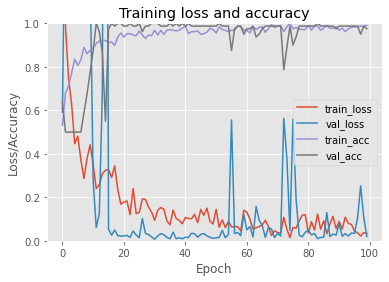

In [9]:
# make predictions on the test set
predY = model.predict(testX)

# classification report
print(classification_report(testY.argmax(axis=1), predY.argmax(axis=1), target_names=le.classes_))
cm = confusion_matrix(testY.argmax(axis=1), predY.argmax(axis=1))
print(cm)

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.title("Training loss and accuracy")
x = np.arange(0, epochs)
plt.plot(x, H.history["loss"], label="train_loss")
plt.plot(x, H.history["val_loss"], label="val_loss")
plt.plot(x, H.history["accuracy"], label="train_acc")
plt.plot(x, H.history["val_accuracy"], label="val_acc")
plt.ylim(0, 1)
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig(figpath)

# save model
model.save(modelpath, save_format="h5")